# 消费平滑

## 概述

在本讲座中，我们将研究Milton Friedman {cite}`Friedman1956`和Robert Hall {cite}`Hall1978`提出的一个著名的"消费函数"模型，该模型旨在拟合一些实证数据模式，这些模式是原始凯恩斯消费函数（在QuantEcon讲座{doc}`几何级数 <geom_series>`中描述的）所忽略的。

在本讲座中，我们将使用矩阵乘法和矩阵求逆来研究通常称为"消费平滑模型"的内容，这些工具与我们在QuantEcon讲座{doc}`现值 <pv>`中使用的工具相同。

{doc}`现值公式<pv>`中提出的公式是消费平滑模型的核心，因为我们将使用它们来定义消费者的"人力财富"。

Milton Friedman的关键想法是，一个人的非金融收入（即他或她从工作中获得的工资）可以被视为该人"人力资本"的股息流，并且可以应用标准资产定价公式来计算一个人的"非金融财富"，这种财富将收入流资本化。

```{note}
正如我们将在QuantEcon讲座{doc}`均衡差异模型 <equalizing_difference>`中看到的，Milton Friedman在他在哥伦比亚大学的博士论文中使用了这个想法，最终发表为{cite}`kuznets1939incomes`和{cite}`friedman1954incomes`。
```

在本讲座中，"现值"或资产价格显式出现需要一段时间，但当它出现时，它将成为一个关键角色。

## 分析
像往常一样，我们将从导入一些Python模块开始。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

该模型描述了一个从时间 $t=0, 1, \ldots, T$ 生活的消费者，接收非金融收入流 $\{y_t\}_{t=0}^T$，并选择消费流 $\{c_t\}_{t=0}^T$。

我们通常认为非金融收入流来自于个人提供劳动的工资。

该模型将非金融收入流作为输入，将其视为"外生"，即不由模型决定。

消费者面临固定的总利率 $R >1$，她可以自由借贷，但有限制条件，我们将在下面描述。

为设置模型，让：

 * $T \geq 2$ 为一个正整数，构成时间范围。

 * $y = \{y_t\}_{t=0}^T$ 为外生的非负非金融收入 $y_t$ 序列。

 * $a = \{a_t\}_{t=0}^{T+1}$ 为金融财富序列。

 * $c = \{c_t\}_{t=0}^T$ 为非负消费率序列。

 * $R \geq 1$ 为固定的金融资产一期总回报率。

 * $\beta \in (0,1)$ 为固定的折现因子。

 * $a_0$ 为给定的初始金融资产水平。

 * $a_{T+1} \geq 0$ 为最终资产的终端条件。

金融财富序列 $a$ 由模型决定。

它必须满足两个**边界条件**：

   * 在时间 0 时必须等于外生值 $a_0$

   * 在时间 $T+1$ 时必须等于或超过外生值 $a_{T+1}$。

**终端条件** $a_{T+1} \geq 0$ 要求消费者不能带着债务离开模型。

（我们很快会看到，一个效用最大化的消费者不会想留下正资产就死去，所以她会安排她的资产使得 $a_{T+1} = 0$。）

消费者面临一系列预算约束，这些约束限制了序列 $(y, c, a)$

$$
a_{t+1} = R (a_t+ y_t - c_t), \quad t =0, 1, \ldots T
$$ (eq:a_t)

方程 {eq}`eq:a_t` 构成了 $T+1$ 个这样的预算约束，每个 $t=0, 1, \ldots, T$ 对应一个。

给定非金融收入序列 $y$，大量的（金融财富，消费）序列对 $(a, c)$ 满足预算约束序列 {eq}`eq:a_t`。

我们的模型有以下逻辑流程：

 * 从外生非金融收入序列 $y$、初始金融财富 $a_0$ 和候选消费路径 $c$ 开始。
 
 * 使用方程系统 {eq}`eq:a_t`（$t=0, \ldots, T$）计算金融财富路径 $a$。
 
 * 验证 $a_{T+1}$ 是否满足终端财富约束 $a_{T+1} \geq 0$。
    
     * 如果满足，声明该候选路径是**预算可行的**。
 
     * 如果候选消费路径不是预算可行的，提出一个不那么贪婪的消费路径并重新开始。
     
下面，我们将描述如何使用线性代数——矩阵求逆和乘法来执行这些步骤。

上述程序似乎是找到"预算可行"消费路径 $c$ 的合理方法，即与外生非金融收入流 $y$、初始金融资产水平 $a_0$ 和终端资产水平 $a_{T+1}$ 一致的路径。

一般来说，有**许多**预算可行的消费路径 $c$。

在所有预算可行的消费路径中，消费者应该想要哪一个？

为回答这个问题，我们最终将使用以下效用函数或**福利标准**来评估替代的预算可行消费路径 $c$：

```{math}
:label: welfare

W = \sum_{t=0}^T \beta^t (g_1 c_t - \frac{g_2}{2} c_t^2 )
```
其中 $g_1 > 0, g_2 > 0$。

当 $\beta R \approx 1$ 时，效用函数 $g_1 c_t - \frac{g_2}{2} c_t^2$ 具有递减的边际效用，这赋予了对非常平滑消费的偏好。

事实上，我们将看到，当 $\beta R = 1$（这是Milton Friedman {cite}`Friedman1956` 和 Robert Hall {cite}`Hall1978` 所假设的条件）时，标准 {eq}`welfare` 会为更平滑的消费路径分配更高的福利。

所谓**更平滑**，我们指的是尽可能接近随时间保持恒定。

模型中内置的对平滑消费路径的偏好使其被称为"消费平滑模型"。

让我们深入进行一些计算，这将帮助我们理解模型的工作原理。

这里我们使用默认参数 $R = 1.05$，$g_1 = 1$，$g_2 = 1/2$，以及 $T = 65$。

我们创建一个Python的**命名元组**来存储这些带有默认值的参数。

In [2]:
ConsumptionSmoothing = namedtuple("ConsumptionSmoothing", 
                        ["R", "g1", "g2", "β_seq", "T"])

def create_consumption_smoothing_model(R=1.05, g1=1, g2=1/2, T=65):
    β = 1/R
    β_seq = np.array([β**i for i in range(T+1)])
    return ConsumptionSmoothing(R, g1, g2, 
                                β_seq, T)

## 弗里德曼-霍尔消费平滑模型

一个关键概念是弥尔顿·弗里德曼所称的时间 0 的"人力"或"非金融"财富：

$$
h_0 \equiv \sum_{t=0}^T R^{-t} y_t = \begin{bmatrix} 1 & R^{-1} & \cdots & R^{-T} \end{bmatrix}
\begin{bmatrix} y_0 \cr y_1  \cr \vdots \cr y_T \end{bmatrix}
$$

时间 0 的人力或非金融财富显然就是消费者非金融收入流 $y$ 的现值。

从形式上看，它与我们在 QuantEcon 讲座 {doc}`现值 <pv>` 中计算的资产价格非常相似。

事实上，这就是为什么弥尔顿·弗里德曼称之为"人力资本"。

通过迭代方程 {eq}`eq:a_t` 并施加终端条件

$$
a_{T+1} = 0,
$$

可以将一系列预算约束 {eq}`eq:a_t` 转换为单一的跨期约束

$$ 
\sum_{t=0}^T R^{-t} c_t = a_0 + h_0. 
$$ (eq:budget_intertemp)

方程 {eq}`eq:budget_intertemp` 表明消费流的现值等于金融和非金融（或人力）财富的总和。

罗伯特·霍尔 {cite}`Hall1978` 证明，当 $\beta R = 1$ 时（这也是弥尔顿·弗里德曼假设的条件），消费者通过设置

$$ 
c_t = c_0 \quad t =0, 1, \ldots, T
$$

来平滑消费是"最优"的。
（稍后我们将提出一个"变分论证"，说明当 $\beta R =1$ 时，这个常数路径最大化了准则 {eq}`welfare`。）

在这种情况下，我们可以使用跨期预算约束来写出

$$
c_t = c_0  = \left(\sum_{t=0}^T R^{-t}\right)^{-1} (a_0 + h_0), \quad t= 0, 1, \ldots, T.
$$ (eq:conssmoothing)

方程 {eq}`eq:conssmoothing` 简明扼要地概括了消费平滑模型。

## 消费平滑模型的机制

按照承诺，我们将提供逐步说明，说明如何使用线性代数（在 Python 中易于实现）来计算消费平滑模型中涉及的所有对象。

在以下计算中，我们将设置 $R > 1$ 的默认值，例如 $R = 1.05$，并且 $\beta = R^{-1}$。

### 步骤 1

对于 $(T+1) \times 1$ 向量 $y$，使用矩阵代数计算 $h_0$

$$
h_0 = \sum_{t=0}^T R^{-t} y_t = \begin{bmatrix} 1 & R^{-1} & \cdots & R^{-T} \end{bmatrix}
\begin{bmatrix} y_0 \cr y_1  \cr \vdots \cr y_T \end{bmatrix}
$$

### 步骤 2

计算时间 0 的消费 $c_0$：

$$
c_t = c_0 = \left( \frac{1 - R^{-1}}{1 - R^{-(T+1)}} \right) (a_0 + \sum_{t=0}^T R^{-t} y_t ) , \quad t = 0, 1, \ldots, T
$$

### 步骤 3

使用方程系统 {eq}`eq:a_t`（对于 $t=0, \ldots, T$）来计算金融财富路径 $a$。

为此，我们将该差分方程系统转换为单个矩阵方程，如下所示：

$$
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 & 0 \cr
-R & 1 & 0 & \cdots & 0 & 0 & 0 \cr
0 & -R & 1 & \cdots & 0 & 0 & 0 \cr
\vdots  &\vdots & \vdots & \cdots & \vdots & \vdots & \vdots \cr
0 & 0 & 0 & \cdots & -R & 1 & 0 \cr
0 & 0 & 0 & \cdots & 0 & -R & 1
\end{bmatrix} 
\begin{bmatrix} a_1 \cr a_2 \cr a_3 \cr \vdots \cr a_T \cr a_{T+1} 
\end{bmatrix}
= R 
\begin{bmatrix} y_0 + a_0 - c_0 \cr y_1 - c_0 \cr y_2 - c_0 \cr \vdots\cr y_{T-1} - c_0 \cr y_T - c_0
\end{bmatrix}
$$

将两边都乘以左侧矩阵的逆矩阵来计算

$$
 \begin{bmatrix} a_1 \cr a_2 \cr a_3 \cr \vdots \cr a_T \cr a_{T+1} \end{bmatrix}
$$

因为我们在计算中已经设定消费者离开模型时恰好没有资产，刚好满足终端条件 $a_{T+1} \geq 0$，所以应该得到

$$
a_{T+1} = 0.
$$

让我们用 Python 代码来验证这一点。
首先，我们用 `compute_optimal` 来实现模型

In [3]:
def compute_optimal(model, a0, y_seq):
    R, T = model.R, model.T

    # 非金融财富
    h0 = model.β_seq @ y_seq     # since β = 1/R

    # c0
    c0 = (1 - 1/R) / (1 - (1/R)**(T+1)) * (a0 + h0)
    c_seq = c0*np.ones(T+1)

    # 检查
    A = np.diag(-R*np.ones(T), k=-1) + np.eye(T+1)
    b = y_seq - c_seq
    b[0] = b[0] + a0

    a_seq = np.linalg.inv(A) @ b
    a_seq = np.concatenate([[a0], a_seq])

    return c_seq, a_seq, h0

我们使用一个例子，其中消费者继承了 $a_0<0$。

这可以被解释为学生贷款。

非金融过程 $\{y_t\}_{t=0}^{T}$ 在 $t=45$ 之前保持恒定且为正值，之后变为零。

生命后期非金融收入的下降反映了退休。

In [4]:
# 金融财富
a0 = -2     # 比如学生贷款

# 非金融收入过程
y_seq = np.concatenate([np.ones(46), np.zeros(20)])

cs_model = create_consumption_smoothing_model()
c_seq, a_seq, h0 = compute_optimal(cs_model, a0, y_seq)

print('检查 a_T+1=0:', 
      np.abs(a_seq[-1] - 0) <= 1e-8)

检查 a_T+1=0: True


下图展示了非金融收入，消费和金融资产的路径。

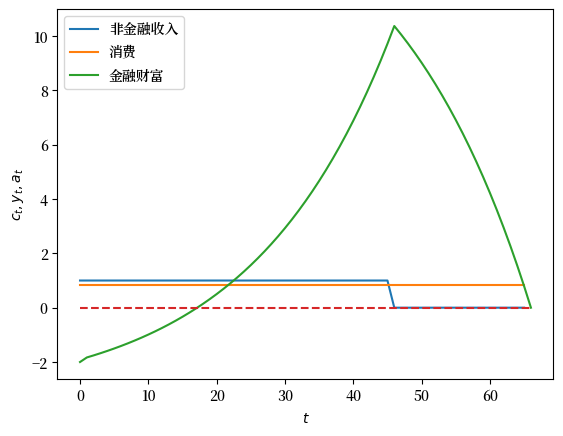

In [5]:
# 序列长度
T = cs_model.T

plt.plot(range(T+1), y_seq, label='非金融收入')
plt.plot(range(T+1), c_seq, label='消费')
plt.plot(range(T+2), a_seq, label='金融财富')
plt.plot(range(T+2), np.zeros(T+2), '--')

plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$c_t,y_t,a_t$')
plt.show()

其中 $a_{T+1} = 0$如我们所预期的一样。
我们可以测量福利标准  {eq}`welfare`

In [6]:
def welfare(model, c_seq):
    β_seq, g1, g2 = model.β_seq, model.g1, model.g2

    u_seq = g1 * c_seq - g2/2 * c_seq**2
    return β_seq @ u_seq

print('福利:', welfare(cs_model, c_seq))

福利: 13.285050962183433


### 实验

在本节中，我们描述了消费序列如何对不同的非金融收入序列做出最佳反应。

首先，我们创建一个名为`plot_cs`的函数，用于为`cs_model`（消费平滑模型）的不同实例生成图表。

这将有助于我们避免为不同的非金融收入序列重写绘图代码。

In [7]:
def plot_cs(model,    # 消费平滑模型      
            a0,       # 初始金融财富
            y_seq     # 非金融收入过程
           ):
    
    # 计算最优消费
    c_seq, a_seq, h0 = compute_optimal(model, a0, y_seq)
    
    # 序列长度
    T = cs_model.T
    
    # 绘图
    plt.plot(range(T+1), y_seq, label='非金融收入')
    plt.plot(range(T+1), c_seq, label='消费')
    plt.plot(range(T+2), a_seq, label='金融财富')
    plt.plot(range(T+2), np.zeros(T+2), '--')
    
    plt.legend()
    plt.xlabel(r'$t$')
    plt.ylabel(r'$c_t,y_t,a_t$')
    plt.show()

在下面的实验中，请研究消费和金融资产序列如何随着不同的非金融收入序列而变化。

#### 实验1：一次性收益/损失

我们首先假设在收入序列$y$的第21年有一次性的意外收入$W_0$。

我们会使$W_0$的数值较大 - 正值表示一次性意外收入，负值表示一次性"灾难"。

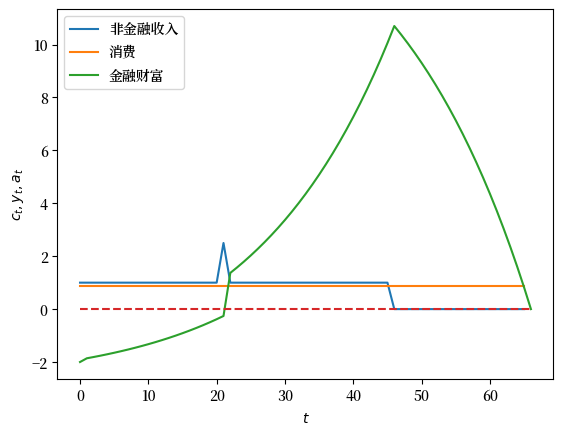

In [8]:
# 一次性意外收入W_0 = 2.5
y_seq_pos = np.concatenate([np.ones(21), np.array([2.5]), np.ones(24), np.zeros(20)])

plot_cs(cs_model, a0, y_seq_pos)

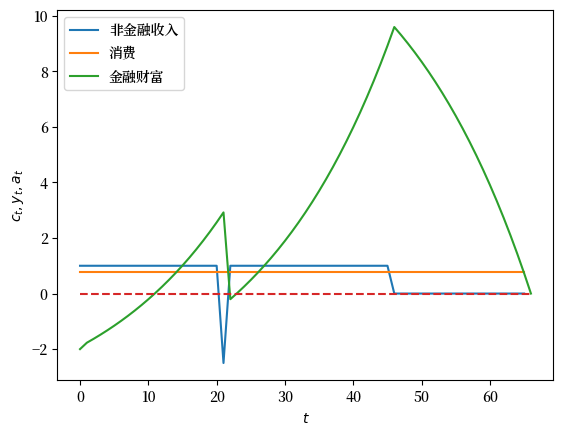

In [9]:
# 灾难 W_0 = -2.5
y_seq_neg = np.concatenate([np.ones(21), np.array([-2.5]), np.ones(24), np.zeros(20)])

plot_cs(cs_model, a0, y_seq_neg)

#### 实验2：永久性工资增加/减少

现在我们假设在$y$序列的第21年，收入永久性增加$W$。

同样，我们可以研究正面和负面的情况。

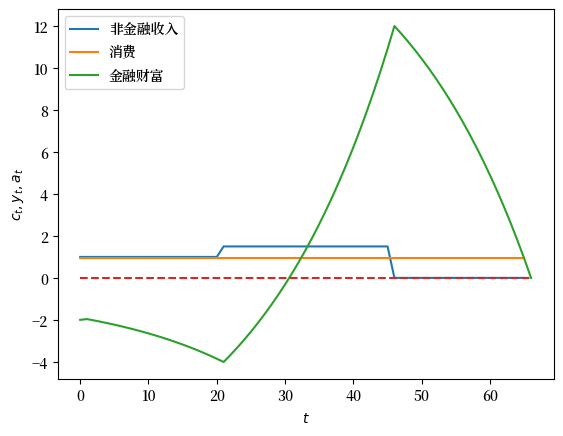

In [10]:
# 永久收入增加 W = 0.5 档 t >= 21
y_seq_pos = np.concatenate(
    [np.ones(21), 1.5*np.ones(25), np.zeros(20)])

plot_cs(cs_model, a0, y_seq_pos)

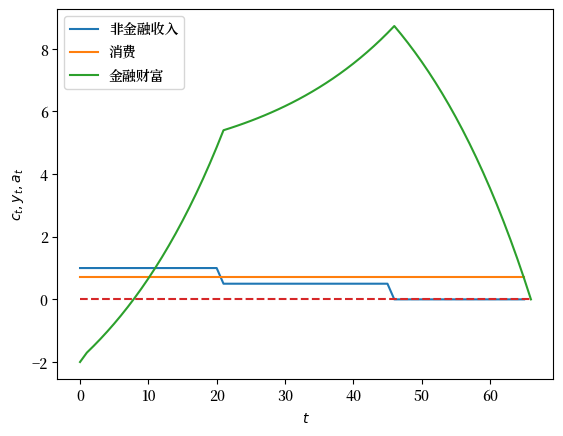

In [11]:
# 永久收入减少 W = -0.5 档 t >= 21
y_seq_neg = np.concatenate(
    [np.ones(21), .5*np.ones(25), np.zeros(20)])

plot_cs(cs_model, a0, y_seq_neg)

#### 实验3：晚期起步者

现在我们模拟一个$y$序列，其中一个人在前46年收入为零，然后在生命的最后20年工作并获得1的收入（一个"晚起步者"）。

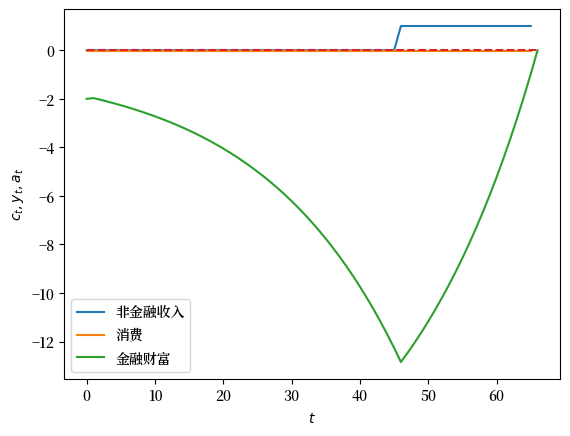

In [12]:
# 晚起步者
y_seq_late = np.concatenate(
    [np.zeros(46), np.ones(20)])

plot_cs(cs_model, a0, y_seq_late)

#### 实验4：几何增长收入者

现在我们模拟一个几何 $y$ 序列，其中一个人在前46年获得 $y_t = \lambda^t y_0$ 的收入。

我们首先尝试 $\lambda = 1.05$

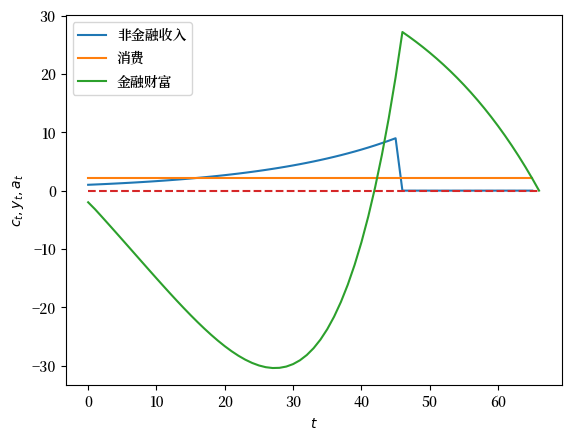

In [13]:
# 几何收入增长者 λ = 1.05
λ = 1.05
y_0 = 1
t_max = 46

# 制造几何序列 y 
geo_seq = λ ** np.arange(t_max) * y_0 
y_seq_geo = np.concatenate(
            [geo_seq, np.zeros(20)])

plot_cs(cs_model, a0, y_seq_geo)

我现在我们展示当$\lambda = 0.95$的行为。

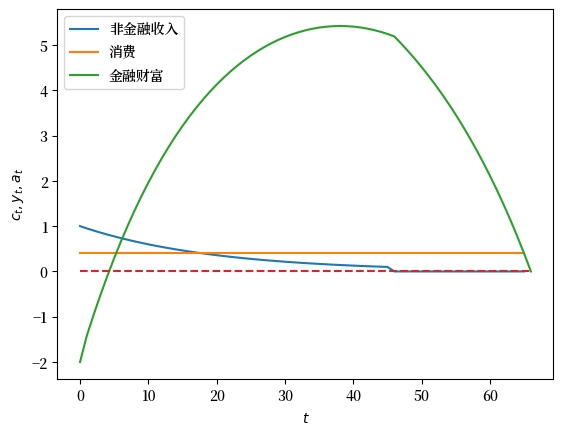

In [14]:
λ = 0.95

geo_seq = λ ** np.arange(t_max) * y_0 
y_seq_geo = np.concatenate(
            [geo_seq, np.zeros(20)])

plot_cs(cs_model, a0, y_seq_geo)

当$\lambda$为负的时候会发生什么

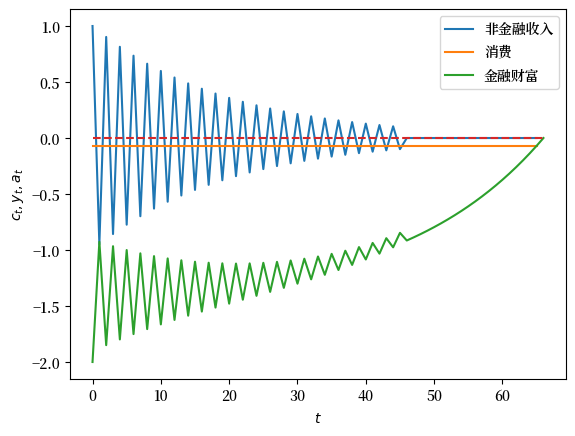

In [15]:
λ = -0.95

geo_seq = λ ** np.arange(t_max) * y_0 
y_seq_geo = np.concatenate(
            [geo_seq, np.zeros(20)])

plot_cs(cs_model, a0, y_seq_geo)

### 可行的消费变化

我们承诺证明恒定消费计划 $c_t = c_0$（对所有 $t$）是最优的。现在让我们来做这个证明。

我们将采用的方法是"变分法"的一个基本例子。让我们深入了解其中的关键思想。

为了探索哪些类型的消费路径能改善福利，我们将创建一个**可接受的消费路径变化序列** $\{v_t\}_{t=0}^T$，满足：

$$
\sum_{t=0}^T R^{-t} v_t = 0
$$

这个等式表明可接受的消费路径变化的**现值**必须为零。

所以我们再次遇到了一个"资产"现值的公式：
   * 我们要求消费路径变化的现值为零。

在这里，我们将限制自己使用一个两参数类的可接受消费路径变化，形式如下：

$$
v_t = \xi_1 \phi^t - \xi_0
$$

我们说是两个而不是三个参数类，因为 $\xi_0$ 将是 $(\phi, \xi_1; R)$ 的函数，以保证变化序列是可行的。

让我们来计算这个函数。

我们要求：

$$
\sum_{t=0}^T R^{-t}\left[ \xi_1 \phi^t - \xi_0 \right] = 0
$$

这意味着：

$$
\xi_1 \sum_{t=0}^T \phi_t R^{-t} - \xi_0 \sum_{t=0}^T R^{-t} = 0
$$

进而意味着：

$$
\xi_1 \frac{1 - (\phi R^{-1})^{T+1}}{1 - \phi R^{-1}} - \xi_0 \frac{1 - R^{-(T+1)}}{1-R^{-1} } =0
$$

最终得到：

$$
\xi_0 = \xi_0(\phi, \xi_1; R) = \xi_1 \left(\frac{1 - R^{-1}}{1 - R^{-(T+1)}}\right) \left(\frac{1 - (\phi R^{-1})^{T+1}}{1 - \phi R^{-1}}\right)
$$ 

这就是我们的 $\xi_0$ 公式。

**关键思想：**如果 $c^o$ 是一个预算可行的消费路径，那么 $c^o + v$ 也是，其中 $v$ 是一个预算可行的变化。

给定 $R$，我们因此有一个两参数类的预算可行变化 $v$，可以用来计算替代消费路径，然后评估它们的福利。

现在让我们计算并绘制消费路径变化。

In [16]:
def compute_variation(model, ξ1, ϕ, a0, y_seq, verbose=1):
    R, T, β_seq = model.R, model.T, model.β_seq

    ξ0 = ξ1*((1 - 1/R) / (1 - (1/R)**(T+1))) * ((1 - (ϕ/R)**(T+1)) / (1 - ϕ/R))
    v_seq = np.array([(ξ1*ϕ**t - ξ0) for t in range(T+1)])
    
    if verbose == 1:
        print('检查:', np.isclose(β_seq @ v_seq, 0))     # since β = 1/R

    c_opt, _, _ = compute_optimal(model, a0, y_seq)
    cvar_seq = c_opt + v_seq

    return cvar_seq

我们绘制$\xi_1 \in \{.01, .05\}$ and $\phi \in \{.95, 1.02\}$的变化

变化 0: ξ1=0.01, ϕ=0.95
检查: True
福利=13.285009346064836
----------------------------------------------------------------
变化 1: ξ1=0.01, ϕ=1.02
检查: True
福利=13.28491163101544
----------------------------------------------------------------
变化 2: ξ1=0.05, ϕ=0.95
检查: True
福利=13.284010559218512
----------------------------------------------------------------
变化 3: ξ1=0.05, ϕ=1.02
检查: True
福利=13.28156768298361
----------------------------------------------------------------


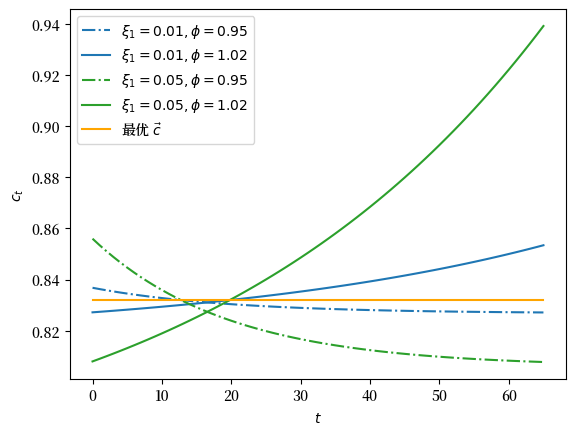

In [17]:
fig, ax = plt.subplots()

ξ1s = [.01, .05]
ϕs= [.95, 1.02]
colors = {.01: 'tab:blue', .05: 'tab:green'}

params = np.array(np.meshgrid(ξ1s, ϕs)).T.reshape(-1, 2)

for i, param in enumerate(params):
    ξ1, ϕ = param
    print(f'变化 {i}: ξ1={ξ1}, ϕ={ϕ}')
    cvar_seq = compute_variation(model=cs_model, 
                                 ξ1=ξ1, ϕ=ϕ, a0=a0, 
                                 y_seq=y_seq)
    print(f'福利={welfare(cs_model, cvar_seq)}')
    print('-'*64)
    if i % 2 == 0:
        ls = '-.'
    else: 
        ls = '-'  
    ax.plot(range(T+1), cvar_seq, ls=ls, 
            color=colors[ξ1], 
            label=fr'$\xi_1 = {ξ1}, \phi = {ϕ}$')

plt.plot(range(T+1), c_seq, 
         color='orange', label=r'最优 $\vec{c}$ ')

plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$c_t$')
plt.show()

我们甚至可以使用 Python 的 `np.gradient` 命令来计算福利对我们两个参数的导数。

我们正在教授**变分法**背后的关键思想。

首先，我们定义关于 $\xi_1$ 和 $\phi$ 的福利函数

In [18]:
def welfare_rel(ξ1, ϕ):
    """
    计算给定 ϕ 和 ξ1 的变分序列的福利
    使用消费平滑模型
    """

    
    cvar_seq = compute_variation(cs_model, ξ1=ξ1, 
                                 ϕ=ϕ, a0=a0, 
                                 y_seq=y_seq, 
                                 verbose=0)
    return welfare(cs_model, cvar_seq)

#向量化函数以允许数组输入
welfare_vec = np.vectorize(welfare_rel)

现在我们可以将福利和$\xi_1$的关系可视化并且计算其导数

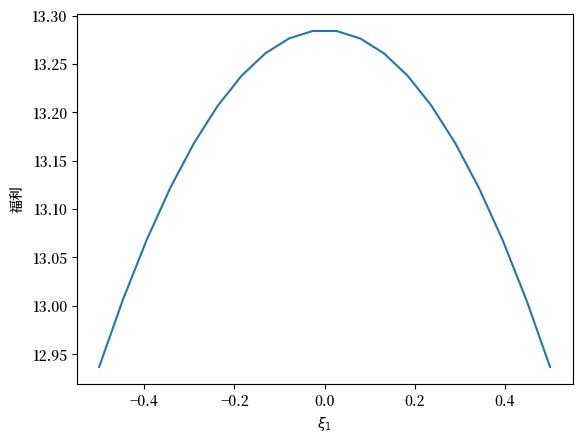

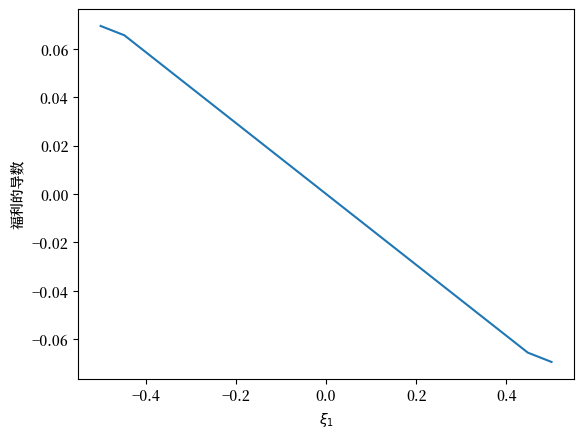

In [19]:
ξ1_arr = np.linspace(-0.5, 0.5, 20)

plt.plot(ξ1_arr, welfare_vec(ξ1_arr, 1.02))
plt.ylabel('福利')
plt.xlabel(r'$\xi_1$')
plt.show()

welfare_grad = welfare_vec(ξ1_arr, 1.02)
welfare_grad = np.gradient(welfare_grad)
plt.plot(ξ1_arr, welfare_grad)
plt.ylabel('福利的导数')
plt.xlabel(r'$\xi_1$')
plt.show()

同理，对$\phi$

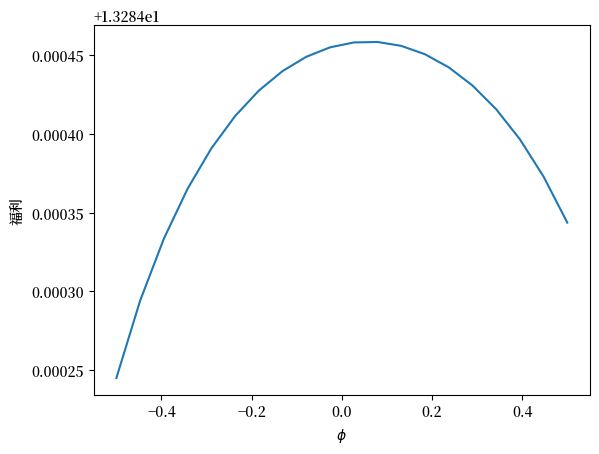

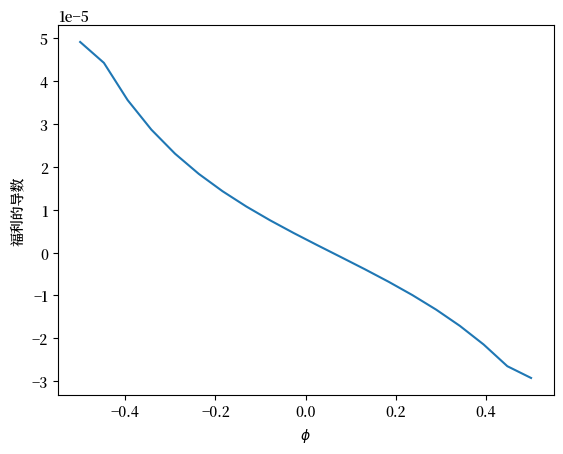

In [20]:
ϕ_arr = np.linspace(-0.5, 0.5, 20)

plt.plot(ξ1_arr, welfare_vec(0.05, ϕ_arr))
plt.ylabel('福利')
plt.xlabel(r'$\phi$')
plt.show()

welfare_grad = welfare_vec(0.05, ϕ_arr)
welfare_grad = np.gradient(welfare_grad)
plt.plot(ξ1_arr, welfare_grad)
plt.ylabel('福利的导数')
plt.xlabel(r'$\phi$')
plt.show()

## 消费平滑模型总结

米尔顿·弗里德曼 {cite}`Friedman1956` 和罗伯特·霍尔 {cite}`Hall1978` 的消费平滑模型是现代宏观经济学的基石，对QuantEcon讲座 {doc}`几何级数 <geom_series>` 中简要描述的凯恩斯"财政政策乘数"的大小有重要影响。

特别是，相对于 {doc}`几何级数 <geom_series>` 中提出的原始凯恩斯消费函数所暗示的乘数，它**降低**了政府支出乘数。

弗里德曼的工作为研究总消费函数和相关政府支出乘数开辟了一个富有启发性的领域，这一领域至今仍然活跃。

## 附录：用线性代数解差分方程

在前面的章节中，我们使用线性代数来解决消费平滑模型。

同样的线性代数工具——矩阵乘法和矩阵求逆——可以用来研究许多其他动态模型。

我们将通过给出几个例子来结束本讲座。

我们将描述一种表示和"求解"线性差分方程的有用方法。

为了生成一些 $y$ 向量，我们只需写下一个具有适当初始条件的线性差分方程，然后使用线性代数来求解。

### 一阶差分方程

我们将从 $\{y_t\}_{t=0}^T$ 的一阶线性差分方程开始：

$$
y_{t} = \lambda y_{t-1}, \quad t = 1, 2, \ldots, T
$$

其中 $y_0$ 是给定的初始条件。

我们可以将这组 $T$ 个方程表示为单个矩阵方程

$$
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 \cr
-\lambda & 1 & 0 & \cdots & 0 & 0 \cr
0 & -\lambda & 1 & \cdots & 0 & 0 \cr
 \vdots & \vdots & \vdots & \cdots & \vdots & \vdots \cr
0 & 0 & 0 & \cdots & -\lambda & 1 
\end{bmatrix} 
\begin{bmatrix}
y_1 \cr y_2 \cr y_3 \cr \vdots \cr y_T 
\end{bmatrix}
= 
\begin{bmatrix} 
\lambda y_0 \cr 0 \cr 0 \cr \vdots \cr 0 
\end{bmatrix}
$$ (eq:first_order_lin_diff)

将 {eq}`eq:first_order_lin_diff` 两边乘以左侧矩阵的逆矩阵，得到解

```{math}
:label: fst_ord_inverse

\begin{bmatrix} 
y_1 \cr y_2 \cr y_3 \cr \vdots \cr y_T 
\end{bmatrix} 
= 
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 \cr
\lambda & 1 & 0 & \cdots & 0 & 0 \cr
\lambda^2 & \lambda & 1 & \cdots & 0 & 0 \cr
 \vdots & \vdots & \vdots & \cdots & \vdots & \vdots \cr
\lambda^{T-1} & \lambda^{T-2} & \lambda^{T-3} & \cdots & \lambda & 1 
\end{bmatrix}
\begin{bmatrix} 
\lambda y_0 \cr 0 \cr 0 \cr \vdots \cr 0 
\end{bmatrix}
```

```{exercise}
:label: consmooth_ex1

为了得到 {eq}`fst_ord_inverse`，我们将 {eq}`eq:first_order_lin_diff` 的两边都乘以矩阵 $A$ 的逆矩阵。请确认
$$
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 \cr
\lambda & 1 & 0 & \cdots & 0 & 0 \cr
\lambda^2 & \lambda & 1 & \cdots & 0 & 0 \cr
 \vdots & \vdots & \vdots & \cdots & \vdots & \vdots \cr
\lambda^{T-1} & \lambda^{T-2} & \lambda^{T-3} & \cdots & \lambda & 1 
\end{bmatrix}
$$
是 $A$ 的逆矩阵，并检查 $A A^{-1} = I$ 是否成立。

```
### 二阶差分方程

对于序列 $\{y_t\}_{t=0}^T$，二阶线性差分方程为：

$$
y_{t} = \lambda_1 y_{t-1} + \lambda_2 y_{t-2}, \quad t = 1, 2, \ldots, T
$$

其中 $y_0$ 和 $y_{-1}$ 是在模型外部确定的两个给定初始条件。

与一阶差分方程类似，我们可以将这 $T$ 个方程表示为单个矩阵方程：

$$
\begin{bmatrix} 
1 & 0 & 0 & \cdots & 0 & 0 & 0 \cr
-\lambda_1 & 1 & 0 & \cdots & 0 & 0 & 0 \cr
-\lambda_2 & -\lambda_1 & 1 & \cdots & 0 & 0 & 0 \cr
 \vdots & \vdots & \vdots & \cdots & \vdots & \vdots \cr
0 & 0 & 0 & \cdots & -\lambda_2 & -\lambda_1 & 1 
\end{bmatrix} 
\begin{bmatrix} 
y_1 \cr y_2 \cr y_3 \cr \vdots \cr y_T 
\end{bmatrix}
= 
\begin{bmatrix} 
\lambda_1 y_0 + \lambda_2 y_{-1} \cr \lambda_2 y_0 \cr 0 \cr \vdots \cr 0 
\end{bmatrix}
$$

再次对等式两边乘以左侧矩阵的逆矩阵即可得到解。

```{exercise}
:label: consmooth_ex2

作为练习，我们要求你表示并求解一个**三阶线性差分方程**。

你必须指定多少个初始条件？
```